# Finishing Up Part II of the Course

Recall that your textbook divides the course material into four parts:
* Part 1: First Steps (chapters 1-4)
* Part 2: Evaluation (chapters 5-7)
* Part 3: More Methods and Fundamentals (chapters 8-11)
* Part 4: Adding Complexity (chapters 12-15)

In this notebook, we finish up covering some topics from Part II (and in particular, chapter 7) that provide a preview of topics (standardization and pipelines) that are covered more thoroughly in later parts of the book. In addition, we provide an introduction to the kaggle platform. For this notebook, there is nothing for you to submit to ICON.

In [1]:
# imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from sklearn import (datasets, neighbors,
                     naive_bayes,
                     model_selection as skms,
                     linear_model, dummy,
                     metrics,
                     pipeline,
                     preprocessing as skpre)
import ipywidgets as widgets
from ipywidgets import interact

## Introduction to Standardization and Pipelines

### Motivation for standardization with the Rio 2016 Olympics Athletes dataset
Recall that we previously worked with a dataset of the athletes from the 2016 Summer Olympics in Rio de Janeiro (downloaded from https://www.kaggle.com/rio2016/olympic-games/data) to predict the olympic sport from height, weight, and age data (e.g., see lec06 notebook). Originally, when reading the data, in addition to some additional pre-processing steps, we converted the height values from meters to inches and the weight values form kg to lbs. Below we repeat these steps, but make conversion to inches/lbs optional. If you repeat running the cell (once with the conversion and once without), you will notice that the difference in range (and variation) of the height/weight values changes substantially. 

In [2]:
convert_height_weight_to_inches_lbs = True

#-----------------------------------------------------------
# Create pandas DataFrame containing height/weight/age data
#-----------------------------------------------------------
rio_athletes_df_orig = pd.read_csv('rio_athletes.csv')
# sex to analyze (feel free to try either one):
sex_to_analyze = 'female'
#sex_to_analyze = 'male'

# limit to one sex and create dataframe of only dob/height/weight/sport columns 
rio_athletes_df = (rio_athletes_df_orig[rio_athletes_df_orig['sex'] == sex_to_analyze])[['dob','height','weight','sport']]

# remove any rows with missing values
rio_athletes_df.dropna(inplace=True)

if (convert_height_weight_to_inches_lbs):
    # convert height from meters to inches
    rio_athletes_df['height'] = rio_athletes_df['height']*39.3701

    # convert weight from kg to lbs
    rio_athletes_df['weight'] = rio_athletes_df['weight']*2.20462

# convert date strings to actual dates
from datetime import datetime
date_format = "%m/%d/%y"
rio_athletes_df['dob'] = rio_athletes_df['dob'].map(lambda x: datetime.strptime(x,date_format))

# add age column (at start of games: 8/5/2016)
from dateutil.relativedelta import relativedelta
olympics_start = datetime.strptime('08/05/2016','%m/%d/%Y')
rio_athletes_df['age'] = rio_athletes_df['dob'].map(lambda x: relativedelta(olympics_start,x).years)
rio_athletes_df['age'] = rio_athletes_df['age'].astype(float)

# drop dob column as we no longer need it
rio_athletes_df = rio_athletes_df.drop(['dob'],axis=1)

# only keep sports of interest 
sports_to_analyze = ['basketball', 'gymnastics', 'weightlifting']
rio_athletes_df = rio_athletes_df[rio_athletes_df['sport'].isin(sports_to_analyze)]
display(rio_athletes_df.head())
display(rio_athletes_df.describe())

FileNotFoundError: [Errno 2] No such file or directory: 'rio_athletes.csv'

As we have done previously, below we split the data into two parts: the first part for training/validation and the second part for testing. In the remainder of this cell, we train a single model on the training/validation data and then evaluate this model on the test data (this is similar to what we had done in the lec06 notebook). If you re-run this cell after re-running the cell above (with convert_height_weight_to_inches_lbs set to False), you will notice the change in accuracy (if any) due to having a different scale/range for the height/weight features. 

In [ ]:
#----------------------------------
# Split into training/testing data 
#----------------------------------
# obtain target as the sport column
rio_target = rio_athletes_df['sport']
# obtain features as the DataFrame with the sport column dropped
rio_features = rio_athletes_df.drop(['sport'],axis=1)

# separate into train/validation and test sets (30% of data for testing)
(rio_train_plus_validation_ftrs, rio_test_ftrs,
 rio_train_plus_validation_tgt, rio_test_tgt) = skms.train_test_split(rio_features,
                                                                      rio_target,
                                                                      test_size=.30,
                                                                      random_state = 39)

#-------------------------------------------------------------
# train/test on one k-NN model (similar to that in lecture 5) 
#-------------------------------------------------------------
model = neighbors.KNeighborsClassifier(n_neighbors=5)
fit = model.fit(rio_train_plus_validation_ftrs, 
                rio_train_plus_validation_tgt)
predictions = fit.predict(rio_test_ftrs)
score = metrics.accuracy_score(rio_test_tgt, predictions)
print(f'Model accuracy: {score:0.2f}')

Model accuracy: 0.87


### Basics of standardization

When we standardize a feature, we subtract the mean (so the new mean is zero) and we divide by the standard deviation (so the standard deviation is 1). Below is a 1-D example from your book.

,x,std-ized
mean,2.500000,4.440892e-17
std,4.670589,1.000000e+00


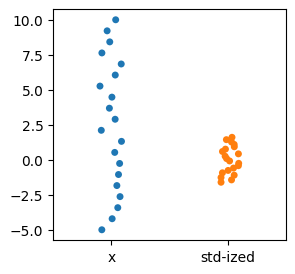

In [ ]:
# FROM BOOK
# 1-D standardization
# place evenly spaced values in a dataframe
xs = np.linspace(-5, 10, 20)
df = pd.DataFrame(xs, columns=['x'])

# center ( - mean) and scale (/ std)
df['std-ized'] = (df.x - df.x.mean()) / df.x.std()

# show original and new data; compute statistics
fig, ax = plt.subplots(1,1,figsize=(3,3))
# note: a stripplot adjusted points with random 'jitter' from 
#       side-to-side so that it is easier to see the distribution
sns.stripplot(data=df) 
display(df.describe().loc[['mean', 'std']])

Below is an example (from your book) of standardizing two features at once. Note that the 'shape' of the data stays the same; only the location and spread of the data have changed.

,x,y
mean,4.440892e-17,6.661338e-17
std,1.000000e+00,1.000000e+00


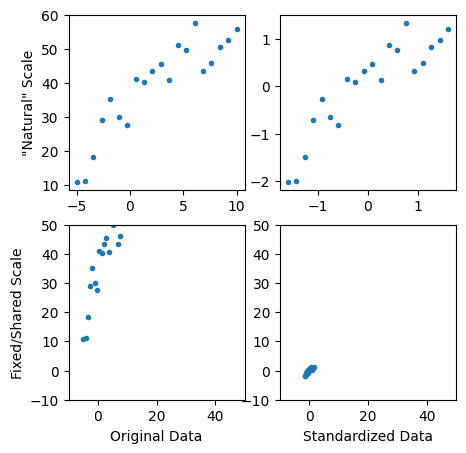

In [ ]:
# FROM BOOK
# 2 1-D standardizations
xs = np.linspace(-5, 10, 20)
ys = 3*xs + 2 + np.random.uniform(20, 40, 20)

df = pd.DataFrame({'x':xs, 'y':ys})
df_std_ized = (df - df.mean()) / df.std()

display(df_std_ized.describe().loc[['mean', 'std']])

# visualizing the standardizations:
fig, ax = plt.subplots(2,2, figsize=(5,5))

ax[0,0].plot(df.x, df.y, '.')
ax[0,1].plot(df_std_ized.x, df_std_ized.y, '.')
ax[0,0].set_ylabel('"Natural" Scale')

ax[1,0].plot(df.x, df.y, '.')
ax[1,1].plot(df_std_ized.x, df_std_ized.y, '.')

ax[1,0].axis([-10, 50, -10, 50])
ax[1,1].axis([-10, 50, -10, 50])

ax[1,0].set_ylabel('Fixed/Shared Scale')
ax[1,0].set_xlabel('Original Data')
ax[1,1].set_xlabel('Standardized Data');

### Revisiting the Rio 2016 Olympics Athletes dataset

Sklearn (as part of sklearn.preprocessing) provides a convenient fit/transform interface (similar to that of models) for performing standardization. Below we standardize all of the features of the Rio 2016 Olympics Athletes dataset before training/testing. Note that the parameters of the scaler are determined from the training set rather than the entire dataset (even when performing standardization on the test-set features). 

In [ ]:
scaler = skpre.StandardScaler()

# get scaling parameters based on training features
scaler.fit(rio_train_plus_validation_ftrs)

# transform training features
rio_train_scaled_ftrs = scaler.transform(rio_train_plus_validation_ftrs)
display(pd.DataFrame(rio_train_scaled_ftrs,columns=rio_train_plus_validation_ftrs.columns).describe())

# transform testing features
rio_test_scaled_ftrs = scaler.transform(rio_test_ftrs)

# train using scaled features and evaluate accuracy 
model = neighbors.KNeighborsClassifier(n_neighbors=5)
fit = model.fit(rio_train_scaled_ftrs, 
                rio_train_plus_validation_tgt)
predictions = fit.predict(rio_test_scaled_ftrs)
score = metrics.accuracy_score(rio_test_tgt, predictions)
print(f'Model accuracy: {score:0.2f}')

,height,weight,age
count,3.190000e+02,3.190000e+02,3.190000e+02
mean,1.979608e-15,-1.614870e-16,-8.909627e-17
std,1.001571e+00,1.001571e+00,1.001571e+00
min,-2.651235e+00,-1.877366e+00,-1.704823e+00
25%,-7.208416e-01,-7.557518e-01,-6.969678e-01
50%,-2.589995e-02,-3.195683e-01,-9.225504e-02
75%,5.146102e-01,5.527985e-01,7.140287e-01
max,2.367788e+00,3.917642e+00,3.536022e+00


Model accuracy: 0.91


## Introduction to Pipelines

Above we only evaluated one model and so used the training/validation set as a single training set (as we initially learned in lec06). However, if we wanted to use a cross-validation strategy to evaluate multiple models, we technically would want to determine the standardization parameters from only the data assigned to the training set in each fold (rather than the training plus validation sets). Properly keeping track of the data to be used for standardization and performing standardization correctly in such a case can be tricky. However, with pipelines, sklearn allows one to effectively 'concatenate' or 'chain' the scaling and model itself as one pipeline (which you can basically treat a a single model). Below we illustrate this process using the Rio 2016 Olympics dataset. 

In [ ]:
scaler = skpre.StandardScaler()

# define models to try
models_to_try = {'nb': naive_bayes.GaussianNB()}
# add k-NN models with various values of k to models_to_try
for k in range(1,36,2):
    models_to_try[f'{k}-NN'] = neighbors.KNeighborsClassifier(n_neighbors=k)

# define pipelines to try as a 'concatenation' of the scaler and model
pipelines_to_try = {}
use_std_scaler = True
if (use_std_scaler):
    for model_name in models_to_try:
        pipelines_to_try[f'std_{model_name}_pipe'] = pipeline.make_pipeline(scaler, 
                                                          models_to_try[model_name])
else:
    pipelines_to_try = models_to_try
    
accuracy_scores = {}
for pipeline_name in pipelines_to_try:
    scores = skms.cross_val_score(pipelines_to_try[pipeline_name],
                                  rio_train_plus_validation_ftrs,
                                  rio_train_plus_validation_tgt,
                                  cv=5,
                                  scoring='accuracy')
    mean_accuracy = scores.mean()
    accuracy_scores[pipeline_name] = mean_accuracy
    print(f'{pipeline_name}: {mean_accuracy:.3f}')
    
best_pipeline_name = max(accuracy_scores,key=accuracy_scores.get)
print(f'\nBest pipeline: {best_pipeline_name} (accuracy = {accuracy_scores[best_pipeline_name]:.3f})')
# set variables for test cell
final_pipeline = pipelines_to_try[best_pipeline_name]

std_nb_pipe: 0.875
std_1-NN_pipe: 0.843
std_3-NN_pipe: 0.865
std_5-NN_pipe: 0.871
std_7-NN_pipe: 0.878
std_9-NN_pipe: 0.878
std_11-NN_pipe: 0.859
std_13-NN_pipe: 0.862
std_15-NN_pipe: 0.859
std_17-NN_pipe: 0.856
std_19-NN_pipe: 0.853
std_21-NN_pipe: 0.837
std_23-NN_pipe: 0.850
std_25-NN_pipe: 0.853
std_27-NN_pipe: 0.856
std_29-NN_pipe: 0.853
std_31-NN_pipe: 0.837
std_33-NN_pipe: 0.843
std_35-NN_pipe: 0.840

Best pipeline: std_7-NN_pipe (accuracy = 0.878)


In [ ]:
rio_test_predictions = (final_pipeline.fit(rio_train_plus_validation_ftrs, 
                                           rio_train_plus_validation_tgt)
                                      .predict(rio_test_ftrs))
test_accuracy = metrics.accuracy_score(rio_test_tgt,
                                       rio_test_predictions)
print(f'Test set accuracy: {test_accuracy:.2f}')

Test set accuracy: 0.90


## Introduction to the Kaggle Platform

In the examples below, we work with data from a kaggle 'knowledge competition' (i.e., a competition specifically designed for learning purposes) to better understand kaggle's platform and one option for obtaining the needed prediction files. (Note: kaggle also has an option for working with notebooks directly online...for now, we won't explore that option. Feel free to explore it on your own.) 

Target column:

* Survived: Survival (0 = No, 1 = Yes)

Other columns:

* PassengerId: unique identifier for each row of data
* Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
* Name: Name of passenger
* Sex: Sex
* Age: Age in years
* SibSp: # of siblings/spouses aboard the Titanic
* Parch: # of parents/children aboard the Titanic
* Ticket: Ticket number
* Fare: Passenger fare
* Cabin: Cabin number
* Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

Additional Notes:

Pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

Age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

SibSp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

Parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [ ]:
# load data
titanic_train_df = pd.read_csv("titanic_train.csv")

# initial exploration of data
display(titanic_train_df.head(10))

# look for columns with missing data
titanic_train_df.info()
# additional observations: 
# PassengerId shouldn't be used as a feature
# Name obviously can't be used directly as a feature (but perhaps we could extract some information from it?)
# Sex is an obvious potential feature as one could expect (knowing the history of the disaster) that females were more likely to survive
# Age seems promising, but has some missing values (should we estimate those somehow?)
# SibSp/Parch seem reasonably promising as well (in case families had a different chance than singles)
# Ticket is hard to know how to parse (but perhaps it has useful information somehow??)
# Fare seems promising, but may be redundant with the ticket class
# Cabin is missing a LOT of data (perhaps we should ignore this information completely for now)
# Intuitively, it is hard to imagine Embarked having much of a direct effect (unless correlated with other features)

# let's focus on only features that seem most useful for now
features = ['Pclass',
            'Sex',
            'Age',
            'SibSp',
            'Parch',
            'Fare']

# add survival column
titanic_train_df = titanic_train_df[features + ['Survived']]

# for now, let's use a simple approach to estimate the age (and consider revisiting this estimate later)
# when it is missing by using the median from the other samples
median_age = titanic_train_df['Age'].median() # note: by default, this will skip NA/null values
print(f'Median age: {median_age:.2f}')
titanic_train_df['Age'] = titanic_train_df['Age'].fillna(median_age)

# convert sex to a 0/1 category
titanic_train_df['Sex'].replace(['male','female'],[0,1],inplace=True)

# display updated table
display(titanic_train_df.head(10))
display(titanic_train_df.info())
display(titanic_train_df.describe())

# also convert to floating type for scaler
titanic_train_ftrs = titanic_train_df[features].astype(float) 
titanic_train_tgt = titanic_train_df['Survived']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Median age: 28.00


,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,3,0,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,1
2,3,1,26.0,0,0,7.9250,1
3,1,1,35.0,1,0,53.1000,1
4,3,0,35.0,0,0,8.0500,0
5,3,0,28.0,0,0,8.4583,0
6,1,0,54.0,0,0,51.8625,0
7,3,0,2.0,3,1,21.0750,0
8,3,1,27.0,0,2,11.1333,1
9,2,1,14.0,1,0,30.0708,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Survived  891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,29.361582,0.523008,0.381594,32.204208,0.383838
std,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.486592
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [ ]:
# use cross-validation to pick best model (use accuracy since 
# kaggle will evaluate on accuracy as well)
models_to_try = {'nb': naive_bayes.GaussianNB()}
# add k-NN models with various values of k to models_to_try
for k in range(1,42,2):
    models_to_try[f'{k}-NN'] = neighbors.KNeighborsClassifier(n_neighbors=k)

scaler = skpre.StandardScaler()
pipelines_to_try = {}
for model_name in models_to_try:
    pipelines_to_try[f'std_{model_name}_pipe'] = pipeline.make_pipeline(scaler, 
                                                      models_to_try[model_name])
features = [
            'Pclass',
            'Sex',
            'Age',
            'SibSp',
            'Parch',
            'Fare'
           ]
    
accuracy_scores = {}
for pipeline_name in pipelines_to_try:
    #loo = skms.LeaveOneOut()
    scores = skms.cross_val_score(pipelines_to_try[pipeline_name],
                                  titanic_train_ftrs[features],
                                  titanic_train_tgt,
                                  #cv=loo,
                                  cv=10,
                                  scoring='accuracy')
    mean_accuracy = scores.mean()
    accuracy_scores[pipeline_name] = mean_accuracy
    print(f'{pipeline_name}: {mean_accuracy:.3f}')

best_pipeline_name = max(accuracy_scores,key=accuracy_scores.get)
print(f'\nBest pipeline: {best_pipeline_name} (accuracy = {accuracy_scores[best_pipeline_name]:.3f})')
# set variables for test cell
final_pipeline = pipelines_to_try[best_pipeline_name]

std_nb_pipe: 0.787
std_1-NN_pipe: 0.749
std_3-NN_pipe: 0.801
std_5-NN_pipe: 0.825
std_7-NN_pipe: 0.810
std_9-NN_pipe: 0.805
std_11-NN_pipe: 0.805
std_13-NN_pipe: 0.805
std_15-NN_pipe: 0.797
std_17-NN_pipe: 0.809
std_19-NN_pipe: 0.814
std_21-NN_pipe: 0.813
std_23-NN_pipe: 0.811
std_25-NN_pipe: 0.813
std_27-NN_pipe: 0.813
std_29-NN_pipe: 0.811
std_31-NN_pipe: 0.814
std_33-NN_pipe: 0.809
std_35-NN_pipe: 0.809
std_37-NN_pipe: 0.809
std_39-NN_pipe: 0.805
std_41-NN_pipe: 0.804

Best pipeline: std_5-NN_pipe (accuracy = 0.825)


In [ ]:
# apply final model to test features
# load data
titanic_test_df = pd.read_csv("titanic_test.csv")
titanic_test_df.info() # check for additional null values

# apply same feature pre-processing steps (using training set for any parameters)
titanic_test_df['Age'] = titanic_test_df['Age'].fillna(median_age)
titanic_test_df['Fare'] = titanic_test_df['Fare'].fillna(titanic_train_df['Fare'].median())
titanic_test_df['Sex'].replace(['male','female'],[0,1],inplace=True)

titanic_test_df[features] = titanic_test_df[features].astype(float)

fit = final_pipeline.fit(titanic_train_ftrs[features], titanic_train_tgt)
predictions = fit.predict(titanic_test_df[features])

# create submission dataframe
submission_df = titanic_test_df[['PassengerId']].copy()
submission_df['Survived'] = predictions
display(submission_df.head())

# write to csv file
submission_df.to_csv('titanic_submission.csv', index=False)

# display message
print("Saved predictions to csv file.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


Saved predictions to csv file.
